# Przykład - CliffWalking-v0

Przyjrzyjmy się konceptom z poprzednich zajęć na przykładzie środowiska [CliffWalking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/).

## Opis

Gra rozpoczyna się, gdy gracz znajduje się na pozycji [3, 0] w świecie o wymiarach 4x12, a cel znajduje się na pozycji [3, 11]. Jeśli gracz dotrze do celu, epizod kończy się.

Przepaść znajduje się na odcinku [3, 1..10]. Jeśli gracz znajdzie się w lokalizacji przepaści, wraca na pozycję początkową.

Gracz wykonuje ruchy, aż osiągnie cel.

Zaadaptowano z Przykładu 6.6 (strona 132) z książki "Reinforcement Learning: An Introduction" autorstwa Suttona i Barto.

In [ ]:
!pip install gymnasium
!pip install renderlab

In [ ]:
import gymnasium as gym
import renderlab as rl
import numpy as np
import pandas as pd

  and should_run_async(code)



In [ ]:
env = gym.make("CliffWalking-v0", render_mode = "rgb_array")
env_unwrapped = env.unwrapped
env = rl.RenderFrame(env, "./output")

observation, info = env.reset()

while True:
  action = env.action_space.sample()
  observation, reward, terminated, truncated, info = env.step(action)
  if terminated or truncated:
    break

env.play()

  and should_run_async(code)



Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t: 100%|█████████▉| 4582/4590 [00:30<00:00, 163.69it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1731877707.967525.mp4, 518400 bytes wanted but 0 bytes read,at frame 4589/4590, at time 152.97/152.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


## Przestrzeń Akcji (*action space*)
Kształt akcji to $ (1,) $ w zakresie $ \{0, 3\} $, wskazującym kierunek ruchu gracza:
- 0: Ruch w górę
- 1: Ruch w prawo
- 2: Ruch w dół
- 3: Ruch w lewo

## Przestrzeń Obserwacji (*observation space*)
Istnieje $ 3 \times 12 + 1 $ możliwych stanów. Gracz nie może znajdować się w przepaści ani w celu, ponieważ dotarcie do celu kończy trajektorię. Pozostałe pozycje to wszystkie pozycje w pierwszych trzech wierszach oraz dolna-lewa komórka.

Obserwacja to wartość reprezentująca bieżącą pozycję gracza w postaci $ \text{current_row} \times \text{ncols} + \text{current_col} $ (gdzie zarówno wiersz, jak i kolumna zaczynają się od 0).

Na przykład, początkowa pozycja może zostać obliczona w następujący sposób:
$ 3 \times 12 + 0 = 36 $.

Obserwacja jest zwracana jako $ \text{int()} $.

## Stan Początkowy
Trajektoria rozpoczyna się, gdy gracz znajduje się w stanie $ [36] $ (lokalizacja $ [3, 0] $).

## Nagroda
Każdy krok w czasie powoduje karę $ -1 $, chyba że gracz wejdzie w przepaść, co skutkuje karą $ -100 $.

## Zakończenie trajektorii
Trajektoria kończy się, gdy gracz wchodzi w stan \( [47] \) (lokalizacja \( [3, 11] \)).

# Przykłady strategii

## Strategia deterministyczna

W przypadku strategii deterministycznej agent zawsze podejmuje takie samo działanie w danym stanie.

In [ ]:
def deterministic_policy(state):
    """
    Deterministic policy for CliffWalking-v0.
    Args:
        state (int): Current state.
    Returns:
        int: Action to take (0=Up, 1=Right, 2=Down, 3=Left).
    """
    grid_width = 12
    grid_height = 4

    row, col = divmod(state, grid_width)

    n_states = env.observation_space.n

    goal_state = n_states - 1
    goal_row, goal_col = divmod(goal_state, grid_width)

    if state == goal_state:
        return None  # Goal reached
    elif row < goal_row:
        return 2  # Move Down
    elif col < goal_col:
        return 1  # Move Right
    else:
        return 0  # Move Up (default)

## Strategia stochastyczna

W przypadku strategii stochastycznej agent wybiera działania probabilistycznie, co pozwala na pewną eksplorację lub uwzględnienie niepewności w procesie podejmowania decyzji.

Epsilon-greedy to prosta strategia wyboru akcji stosowana w uczeniu ze wzmocnieniem w celu zrównoważenia eksploracji (próbowania nowych akcji w poszukiwaniu lepszych nagród) i eksploatacji (wybierania najlepiej znanej akcji na podstawie aktualnej wiedzy).

In [ ]:
def stochastic_policy(state, Q, epsilon=0.1):
    """
    Stochastic policy for CliffWalking-v0 using ε-greedy.
    Args:
        state (int): Current state.
        Q (ndarray): Q-value table.
        epsilon (float): Exploration probability.
    Returns:
        int: Selected action.
    """
    # With probability 1-ε, take the greedy action
    if np.random.rand() > epsilon:
        return np.argmax(Q[state])
    # With probability ε, take a random action
    else:
        return np.random.choice(env.action_space.n)

## Strategia parametryzowana stochastyczna

Probabilistyczna strategia, w której prawdopodobieństwa wyboru każdej akcji są określane przez funkcję sparametryzowaną, taką jak sieć neuronowa lub funkcja softmax oparta na sparametryzowanych preferencjach.

Oto przykład implementacji parametryzowanej stochastycznej strategii z wykorzystaniem funkcji softma:.

1. **Reprezentacja strategii:**
   - Strategia jest reprezentowana jako funkcja parametryczna $ \pi(a|s; \theta) $, gdzie $ \theta $ to parametry.
   - Tutaj $ \theta $ to tablica 2D, w której każdy wiersz odpowiada stanowi, a każda kolumna odpowiada preferencji dla danej akcji.

2. **Funkcja Softmax:**
   - Przekształca preferencje akcji na rozkład prawdopodobieństwa:
     $
     \pi(a|s) = \frac{\exp(\theta[s, a])}{\sum_{a'} \exp(\theta[s, a'])}
     $

3. **Próbkowanie akcji:**
   - Akcje są próbnikowane zgodnie z obliczonymi prawdopodobieństwami, zapewniając stochastyczność.

4. **Aktualizacja parametrów:**
   - Parametry są aktualizowane przy użyciu twierdzenia o gradientach strategii:
     $
     \theta \leftarrow \theta + \alpha \cdot \text{Advantage} \cdot \nabla \log \pi(a|s)
     $

---

In [ ]:
import numpy as np

class StochasticPolicy:
    def __init__(self, n_states, n_actions):
        """
        Initialize the parameterized stochastic policy.
        Args:
            n_states (int): Number of states.
            n_actions (int): Number of actions.
        """
        self.n_states = n_states
        self.n_actions = n_actions
        # Initialize parameters (randomly)
        self.parameters = np.random.rand(n_states, n_actions)

    def get_action_probs(self, state):
        """
        Get the action probabilities for a given state using a softmax function.
        Args:
            state (int): Current state.
        Returns:
            ndarray: Probabilities of each action.
        """
        preferences = self.parameters[state]
        exp_preferences = np.exp(preferences - np.max(preferences))  # Stabilized softmax
        return exp_preferences / np.sum(exp_preferences)

    def sample_action(self, state):
        """
        Sample an action based on the parameterized policy.
        Args:
            state (int): Current state.
        Returns:
            int: Selected action.
        """
        action_probs = self.get_action_probs(state)
        return np.random.choice(self.n_actions, p=action_probs)

    def update_parameters(self, state, action, advantage, learning_rate=0.01):
        """
        Update the policy parameters using policy gradient.
        Args:
            state (int): Current state.
            action (int): Action taken.
            advantage (float): Advantage (e.g., from a critic or baseline).
            learning_rate (float): Learning rate for parameter updates.
        """
        action_probs = self.get_action_probs(state)
        grad = -action_probs
        grad[action] += 1  # Gradient of log π(a|s)
        self.parameters[state] += learning_rate * advantage * grad


# Funkcje wartości (*value functions*)

Często przydatne jest poznanie wartości stanu (*state*) lub pary stan-akcja (*state-action*). Przez wartość rozumiemy oczekiwany zwrot, jeśli rozpoczniemy w danym stanie lub parze stan-działanie, a następnie będziemy działać zgodnie z określoną strategią do końca trajektorii.
Kwantyfikują one „pożądaność” stanów lub działań na podstawie długoterminowych nagród, do których mogą prowadzić.
Funkcje wartości są wykorzystywane, w taki czy inny sposób, w prawie każdym algorytmie RL.

1. **Funkcja wartości dla strategii (On-Policy Value Function)**, $V^\pi(s)$, która podaje oczekiwany zwrot, jeśli rozpoczniemy w stanie $s$ i będziemy kontynuować działanie do końca zgodnie ze strategią $\pi$:
   $$
   V^\pi(s) = \mathbb{E}_{\tau \sim \pi} \left[ R(\tau) \mid s_0 = s \right]
   $$

2. **Funkcja wartości-akcji dla strategii (On-Policy Action-Value Function)**, $Q^\pi(s, a)$, która podaje oczekiwany zwrot, jeśli zaczniesz w stanie $s$, wykonasz dowolne działanie $a$ (które może nie pochodzić ze strategii), a potem będziesz działać zgodnie ze strategią $\pi$:
   $$
   Q^\pi(s, a) = \mathbb{E}_{\tau \sim \pi} \left[ R(\tau) \mid s_0 = s, a_0 = a \right]
   $$

3. **Optymalna funkcja wartości (Optimal Value Function)**, $V^*(s)$, która podaje oczekiwany zwrot, jeśli zaczniesz w stanie $s$ i zawsze działasz zgodnie z optymalną strategią w środowisku:
   $$
   V^*(s) = \max_{\pi} \mathbb{E}_{\tau \sim \pi} \left[ R(\tau) \mid s_0 = s \right]
   $$

4. **Optymalna funkcja wartości-akcji (Optimal Action-Value Function)**, $Q^*(s, a)$, która podaje oczekiwany zwrot, jeśli zaczniesz w stanie $s$, wykonasz dowolne działanie $a$, a potem będziesz działać zgodnie z optymalną strategią w środowisku:
   $$
   Q^*(s, a) = \max_{\pi} \mathbb{E}_{\tau \sim \pi} \left[ R(\tau) \mid s_0 = s, a_0 = a \right]
   $$


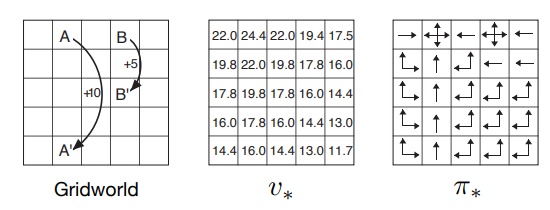

-  Pierwszy rysunek przedstawia środowisko, punkty A i B to specjalne stany z przypisanymi nagrodami. Przejście z $A$ do $A'$ daje nagrodę $+10$, natomiast z $B$ do $B'$ - $+5$
- Drugi reprezentuje wartość stanu dla optymalnej strategii ($v_*$), czyli oczekiwaną sumę nagród, jaką agent może uzyskać, zaczynając w danym stanie i podążając optymalnie. Liczby w siatce oznaczają wartość każdego stanu:
wyższe liczby sugerują, że stan jest bardziej "opłacalny". Stany bliżej specjalnych stanów A i B mają wyższe wartości, bo te stany prowadzą do większych nagród.
- Trzeci pokazuje kierunki ruchu, które agent powinien wybrać w danym stanie, aby zmaksymalizować swoją oczekiwaną nagrodę


## $J(\pi)$ a Funkcja wartości


|                | **Co mierzy**                                         | **Use Case**                                                                 |
|---------------------------|-------------------------------------------------------------|------------------------------------------------------------------------------|
| **$J(\pi)$**              | Ogólną wydajność polityki (pojedyncza wartość skalarna)              | Porównywanie lub ocenianie polityk na poziomie globalnym.                                |
| **Value Function**        | Wydajność konkretnych stanów lub par stan-akcja      | Ulepszanie polityk, podejmowanie decyzji i przyspieszanie uczenia.          |

# Ewaluacja strategii (*policy evaluation (prediction)*)

Celem jest wyznaczenie wartości (*value*) do każdego stanu (lub pary stan-akcja) w ramach strategii.
Nie pozwala ona na znalezienie optymalnej strategii, jedynie wyznacza wartości stanów dla dowolnej strategii $\pi$.

Here is the Polish translation (with RL terminology):

## Znaczenie

1. **Podstawa do Udoskonalania Strategii**: Ewaluacja strategii jest kluczowym etapem w wielu algorytmach RL, takich jak Iteracja Strategii (*Policy Iteration*) i metody Aktor-Krytyk (*Actor-Critic*). Gdy funkcja wartości dla strategii jest znana, strategię można ulepszyć, działając zachłannie w odniesieniu do funkcji wartości.

2. **Zrozumienie Wydajności Strategii**: Ocena dostarcza ilościowego wskaźnika, jak dobra jest dana strategia, co jest kluczowe przy porównywaniu różnych strategii i wyborze najlepszej.

3. **Podstawa do Wyprowadzenia Optymalnej Strategii**: W algorytmach takich jak Iteracja Strategii (*Policy Iteration*) lub Iteracja Wartości (*Value Iteration*), iteracyjny proces oceny i doskonalenia prowadzi do optymalnej strategii.

4. **Możliwość Planowania**: Znajomość funkcji wartości pozwala agentowi przewidywać długoterminowe konsekwencje działań bez ich faktycznego wykonywania, co jest kluczowe w *model-based RL*.

Poniżej przyjrzymy się dwóm metodom znajdowania wartości stanów: metodą programowania dynamicznego oraz Monte Carlo dla środowiska `CliffWalking_v0`.

## Programowanie Dynamiczne

Programowanie dynamiczne (*dynamic programming, DP*) to metoda rozwiązywania problemów poprzez podział ich na mniejsze podproblemy i efektywne rozwiązywanie tych podproblemów. W ewaluacji strategii DP wykorzystuje **Równanie Bellmana** (*bellman equation*) do iteracyjnego obliczania funkcji wartości.

Założenia wykonane na potrzeby DP:
- **Model środowiska jest znany** ($ P(s'|s, a) $ oraz $ R(s, a, s') $).  
- Przestrzenie stanów i akcji są wystarczająco małe, aby można było przechowywać i obliczać wszystkie wartości (słaba skalowalność).

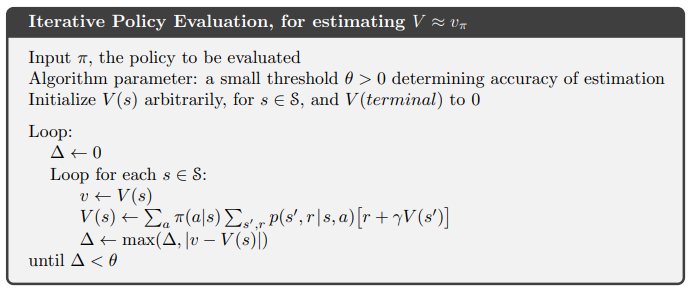

### Równanie Bellmana

Dla strategii $\pi(a|s)$, równanie Bellmana dla funkcji wartości $V(s)$ jest zapisane jako:

$$
V(s) = \sum_a \pi(a|s) \sum_{s'} P(s'|s, a) \left[ R(s, a, s') + \gamma V(s') \right]
$$

**$V(s)$:** **Wartość stanu**: wartość pożądana. Pokazuje oczekiwaną łączną nagrodę zaczynając od stanu $s$, postępując zgodnie ze strategią $\pi$.

**$\pi(a|s)$:** **Strategia**: prawdopodobieństwo podjęcia akcji $a$ w stanie $s$. Jeśli strategia jest deterministyczna (zawsze podejmuje tę samą akcję), wówczas $\pi(a|s) = 1$ dla wybranej akcji, a $0$ dla pozostałych.

**$P(s'|s, a)$:** **Prawdopodobieństwo przejścia**: prawdopodobieństwo, że po wykonaniu akcji $a$ w stanie $s$ znajdziesz się w stanie $s'$. Pochodzi ze środowiska.

**$R(s, a, s')$:** **Nagroda**: Natychmiastowa nagroda za przejście ze stanu $s$ do $s'$ przy użyciu akcji $a$.

**$\gamma$:** **Współczynnik dyskontowy**: Wartość pomiędzy $0$ a $1$. Kontroluje, jak daleko „zależy nam” na przyszłości.

**$\gamma V(s')$:** **Przyszła nagroda**: Wartość kolejnego stanu $s'$, zdyskontowana przez $\gamma$, ponieważ dotyczy przyszłości.

In [ ]:
import numpy as np
import gymnasium as gym

def policy_evaluation(env, policy, gamma=0.9, theta=1e-4):
    """
    Policy evaluation using the Bellman equation.
    Args:
        env: OpenAI Gym environment.
        policy: Policy function that takes a state and returns an action.
        gamma: Discount factor.
        theta: Convergence threshold.
    Returns:
        np.ndarray: Value function for all states.
    """
    n_states = env.observation_space.n
    V = np.zeros(n_states)  # Initialize value function

    while True:
        delta = 0  # Change in value function for convergence check
        for state in range(n_states):
            action = policy(state)
            if action is None:  # Goal state
                continue

            # Bellman update for the value function
            new_value = 0
            for prob, next_state, reward, _ in env_unwrapped.P[state][action]:
                new_value += prob * (reward + gamma * V[next_state])

            # Update delta for convergence
            delta = max(delta, abs(new_value - V[state]))
            V[state] = new_value

        if delta < theta:  # Convergence condition
            break

    return V

value_function = policy_evaluation(env, deterministic_policy)
rows, cols = 4, 12  # Default for CliffWalking-v0
value_function = value_function.reshape(rows, cols)  # Reshape into grid

df = pd.DataFrame(value_function, columns=[f"Col {i}" for i in range(cols)])
print("Policy Evaluation Value Function for Cliff Walking:")
print(df)

Policy Evaluation Value Function for Cliff Walking:
        Col 0       Col 1       Col 2       Col 3       Col 4       Col 5  \
0 -731.709179 -811.899179 -811.899179 -811.899179 -811.899179 -811.899179   
1 -811.899179 -900.999179 -900.999179 -900.999179 -900.999179 -900.999179   
2 -900.999179 -999.999179 -999.999179 -999.999179 -999.999179 -999.999179   
3 -999.999179 -999.999261 -999.999261 -999.999261 -999.999261 -999.999261   

        Col 6       Col 7       Col 8       Col 9      Col 10  Col 11  
0 -811.899179 -811.899179 -811.899179 -811.899179 -811.899179   -2.71  
1 -900.999179 -900.999179 -900.999179 -900.999179 -900.999179   -1.90  
2 -999.999179 -999.999179 -999.999179 -999.999179 -999.999179   -1.00  
3 -999.999261 -999.999261 -999.999261 -999.999261   -1.000000    0.00  


## Metoda Monte Carlo

Ewaluacja Monte Carlo (MC) to metoda wykorzystująca **estymację** funkcji wartości.

Kluczową ideą Monte Carlo jest uczenie się na podstawie doświadczenia poprzez symulację epizodów (sekwencji akcji, stanów i nagród) w środowisku. Zamiast korzystać z matematycznych modeli środowiska, MC wykorzystuje średnie z zaobserwowanych nagród do oszacowania funkcji wartości.

Predykcja Monte Carlo (MC) działa bez znajomości dynamiki przejść $P(s'|s, a)$. Zamiast tego uczy się bezpośrednio na podstawie zaobserwowanych epizodów poprzez próbkowanie trajektorii.
To czyni ją idealnym rozwiązaniem dla scenariuszy w rzeczywistym świecie, gdzie środowisko jest złożone lub nie może być w pełni zamodelowane.

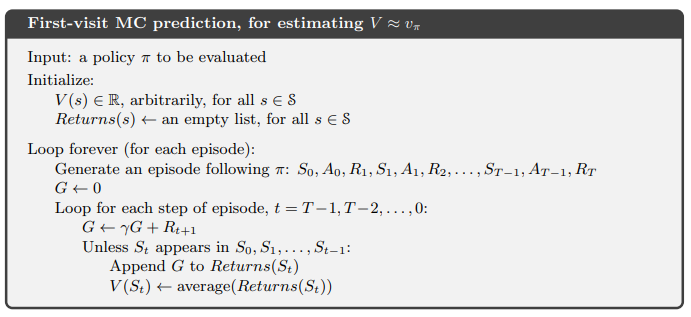

In [ ]:
import numpy as np
import pandas as pd
import gymnasium as gym

def monte_carlo_policy_evaluation(env, policy, gamma=0.9, episodes=1):
    n_states = env.observation_space.n
    returns_sum = np.zeros(n_states)
    returns_count = np.zeros(n_states)
    V = np.zeros(n_states)

    for _ in range(episodes):
        episode = []
        state = env.reset()[0]
        done = False

        while not done:
            action = policy(state)
            next_state, reward, done, _, _ = env.step(action)
            episode.append((state, reward))
            state = next_state

        G = 0
        visited_states = set()
        for state, reward in reversed(episode):
            G = reward + gamma * G
            if state not in visited_states:
                visited_states.add(state)
                returns_sum[state] += G
                returns_count[state] += 1
                V[state] = returns_sum[state] / returns_count[state]

    return V

env = gym.make("CliffWalking-v0")
value_function_mc = monte_carlo_policy_evaluation(env, deterministic_policy, episodes=10)

rows, cols = 4, 12
value_function_grid = value_function_mc.reshape(rows, cols)

df = pd.DataFrame(value_function_grid, columns=[f"Col {i}" for i in range(cols)])
print("Policy Evaluation Value Function for Cliff Walking:")
print(df)


# Zadanie

- Jeżeli uruchomisz funkcję `monte_carlo_policy_evaluation`, wpadnie ona w pętlę nieskończoną. Dlaczego? Zapoznaj się z kodem i napraw kod w taki sposób, aby poprawnie wyznaczyć wartości stanów.
- Porównaj wyznaczone wartości stanów z wynikami uzyskanymi metodą korzystającą z równania Bellmana. Co zauważasz?
- Co należy zmienić w metodzie `monte_carlo_policy_evaluation` aby wyniki były dokładniejsze? Dokonaj zmiany i porównaj wyniki ponownie.